In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import _pickle as pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pickle

In [42]:
with open(r"data\refined_profiles.pkl", 'rb') as fp:
    df = pickle.load(fp)

df.head()

,Bios,Movies,Religion,Music,Politics,Social Media,Sports,Age
0,Typical twitter fanatic. Infuriatingly humble ...,"[Thriller, Action]",Buddhist,"[Gospel, Pop, Rock]",Progressive,"[Twitter, Reddit, Instagram]","[Basketball, Football, Hockey]",19
1,Web junkie. Analyst. Infuriatingly humble intr...,"[Comedy, Drama]",Spiritual,"[HipHop, Pop]",Conservative,"[Twitter, Facebook]","[Basketball, Soccer, Hockey]",19
2,Avid web maven. Food practitioner. Gamer. Twit...,"[Horror, Comedy]",Christian,"[HipHop, Rock]",Moderate,"[Reddit, Youtube]","[Baseball, Football]",21
3,Twitteraholic. Extreme web fanatic. Food buff....,"[Adventure, Comedy]",Agnostic,[Rock],Moderate,"[Facebook, Youtube]","[Basketball, Football, Hockey]",25
4,Bacon enthusiast. Falls down a lot. Freelance ...,"[Action, Adventure, Drama]",Hindu,"[Latin, Rock, HipHop]",Conservative,"[Twitter, TikTok, Youtube]","[Hockey, Football, Basketball]",19


# Data Processing

## Vectorizing

In [123]:
# converting preferences to String which can later be easily vectorized
def to_string(preference):
    if isinstance(preference, list):
        return ' '.join(preference).strip()
    else:
        return preference
    
for col in df.columns:
    # element wise operation on all column using a call backfunction
    df[col] = df[col].apply(to_string)
    


In [124]:
df.head()

,Bios,Movies,Religion,Music,Politics,Social Media,Sports,Age
0,Typical twitter fanatic. Infuriatingly humble ...,Thriller Action,Buddhist,Gospel Pop Rock,Progressive,Twitter Reddit Instagram,Basketball Football Hockey,19
1,Web junkie. Analyst. Infuriatingly humble intr...,Comedy Drama,Spiritual,HipHop Pop,Conservative,Twitter Facebook,Basketball Soccer Hockey,19
2,Avid web maven. Food practitioner. Gamer. Twit...,Horror Comedy,Christian,HipHop Rock,Moderate,Reddit Youtube,Baseball Football,21
3,Twitteraholic. Extreme web fanatic. Food buff....,Adventure Comedy,Agnostic,Rock,Moderate,Facebook Youtube,Basketball Football Hockey,25
4,Bacon enthusiast. Falls down a lot. Freelance ...,Action Adventure Drama,Hindu,Latin Rock HipHop,Conservative,Twitter TikTok Youtube,Hockey Football Basketball,19


In [125]:
vectorizers = {}
def vectorize(df, columns):
    # select the first column in database
    column_name = columns[0]

    # base condition, went through all columns
    if column_name not in ['Bios', 'Movies','Religion', 'Music', 'Politics', 'Social Media', 'Sports']:
        return df
        
    # they are stored as categorical values so can simply use .cat.codes
    if column_name in ['Religion','Politics']:
        df[column_name.lower()] = df[column_name].cat.codes
        df = df.drop(column_name, axis=1)
        return vectorize(df, df.columns)
   
    else:
        # try:
        vectorizer = CountVectorizer()
        # first one Bios
        vec = vectorizer.fit_transform(df[column_name].astype(str))
        vectorizers[column_name] = vec
        df_words = pd.DataFrame(vec.toarray(), columns=vectorizer.get_feature_names_out())
        new_df = pd.concat([df, df_words], axis=1)
        # dropping original column
        new_df = new_df.drop(column_name, axis=1)
        # except:
        #     print(f"problem {column_name}")
            
        # contains vectorized words
        
    
        return vectorize(new_df, new_df.columns)

In [111]:
df.index[-1] + 1

6600

In [127]:
categories = [
    'Typical twitter fanatic.',
    ['one', 'two'],
    'Christian',
    ['one', 'two'],
    'Progressive',
    ['one', 'two'],
    ['one', 'two'],
    20
]

In [128]:
profile_index = df.index[-1] + 1
profile = pd.DataFrame(columns=df.columns, index=[profile_index])
profile

,Bios,Movies,Religion,Music,Politics,Social Media,Sports,Age
6600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [129]:
for i, name in enumerate(list(df.columns)):
    profile.at[profile_index, name] = categories[i]

In [130]:
profile

,Bios,Movies,Religion,Music,Politics,Social Media,Sports,Age
6600,Typical twitter fanatic.,"[one, two]",Christian,"[one, two]",Progressive,"[one, two]","[one, two]",20


In [134]:
profile['Religion'] = pd.Categorical(profile.Religion, ordered=True,
                            categories=['Catholic',
                                        'Christian',
                                        'Jewish',
                                        'Muslim',
                                        'Hindu',
                                        'Buddhist',
                                        'Spiritual',
                                        'Other',
                                        'Agnostic',
                                        'Atheist'])

profile['Politics'] = pd.Categorical(profile.Politics, ordered=True,
                                categories=['Liberal',
                                            'Progressive',
                                            'Centrist',
                                            'Moderate',
                                            'Conservative'])

In [139]:
for col in profile.columns:
    # element wise operation on all column using a call backfunction
    profile[col] = profile[col].apply(to_string)

In [144]:
profile

,Bios,Movies,Religion,Music,Politics,Social Media,Sports,Age
6600,Typical twitter fanatic.,one two,Christian,one two,Progressive,one two,one two,20


In [145]:
vect_profile = vectorize(profile, profile.columns)

In [146]:
vect_profile

,Age,fanatic,twitter,typical,nan,one,two,religion,nan,one,two,politics,nan,one,two,nan,one,two
6600,20.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,1.0,1.0,1.0,0.0,1.0,1.0,-1.0,0.0,1.0,1.0,-1.0,0.0,1.0,1.0,0.0,1.0,1.0
1,NaN,NaN,NaN,NaN,1.0,0.0,0.0,-1.0,1.0,0.0,0.0,-1.0,1.0,0.0,0.0,1.0,0.0,0.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,-1.0,1.0,0.0,0.0,1.0,0.0,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,1.0,0.0,0.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0


In [147]:
df

,Bios,Movies,Religion,Music,Politics,Social Media,Sports,Age
0,Typical twitter fanatic. Infuriatingly humble ...,Thriller Action,Buddhist,Gospel Pop Rock,Progressive,Twitter Reddit Instagram,Basketball Football Hockey,19
1,Web junkie. Analyst. Infuriatingly humble intr...,Comedy Drama,Spiritual,HipHop Pop,Conservative,Twitter Facebook,Basketball Soccer Hockey,19
2,Avid web maven. Food practitioner. Gamer. Twit...,Horror Comedy,Christian,HipHop Rock,Moderate,Reddit Youtube,Baseball Football,21
3,Twitteraholic. Extreme web fanatic. Food buff....,Adventure Comedy,Agnostic,Rock,Moderate,Facebook Youtube,Basketball Football Hockey,25
4,Bacon enthusiast. Falls down a lot. Freelance ...,Action Adventure Drama,Hindu,Latin Rock HipHop,Conservative,Twitter TikTok Youtube,Hockey Football Basketball,19
...,...,...,...,...,...,...,...,...
6595,Typical pop culture nerd. Infuriatingly humble...,Thriller Comedy Action,Catholic,Pop Rock HipHop,Liberal,Facebook Reddit Youtube,Baseball,28
6596,Avid web junkie. Lifelong alcohol guru. Hardco...,Action Horror,Spiritual,Rock Classical,Conservative,Facebook Instagram Youtube,Baseball Hockey,24
6597,Music ninja. Bacon fanatic. Reader. Total comm...,Adventure Drama,Catholic,Country HipHop,Progressive,Facebook Youtube,Football Basketball,24
6598,Communicator. Bacon lover. Award-winning intro...,Adventure Drama,Christian,Country Pop Rock,Moderate,Pinterest Facebook Reddit,Baseball Football,20


In [148]:
vect_df = vectorize(df, df.columns)

In [149]:
vectorizers

{'Bios': <Compressed Sparse Row sparse matrix of dtype 'int64'
 	with 85475 stored elements and shape (6600, 110)>,
 'Movies': <Compressed Sparse Row sparse matrix of dtype 'int64'
 	with 16515 stored elements and shape (6600, 9)>,
 'Music': <Compressed Sparse Row sparse matrix of dtype 'int64'
 	with 16206 stored elements and shape (6600, 9)>,
 'Social Media': <Compressed Sparse Row sparse matrix of dtype 'int64'
 	with 15699 stored elements and shape (6600, 9)>,
 'Sports': <Compressed Sparse Row sparse matrix of dtype 'int64'
 	with 15306 stored elements and shape (6600, 6)>}

In [150]:
with open('vectorizers.pkl', 'wb') as f:
    pickle.dump(vectorizers, f)

In [7]:
vect_df

,Age,advocate,aficionado,alcohol,alcoholaholic,amateur,analyst,animals,apathy,avid,...,snapchat,tiktok,twitter,youtube,baseball,basketball,football,hockey,other,soccer
0,19,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,1,1,0,0
1,19,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,1,0,1
2,21,0,0,0,0,0,0,0,0,1,...,0,0,0,1,1,0,1,0,0,0
3,25,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,1,1,0,0
4,19,0,0,0,0,0,0,0,0,0,...,0,1,1,1,0,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6595,28,0,0,1,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
6596,24,0,0,1,0,0,0,0,0,1,...,0,0,0,1,1,0,0,1,0,0
6597,24,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,1,0,0,0
6598,20,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0


## Scaling

In [8]:
# [0, 1]
scaler = MinMaxScaler()

vect_df_transformed = scaler.fit_transform(vect_df)

vect_df = pd.DataFrame(vect_df_transformed, 
                       index = vect_df.index, 
                       columns=vect_df.columns)

In [13]:
import joblib
joblib.dump(scaler, 'data\\scaler.joblib')

['data\\scaler.joblib']

In [ ]:
vect_df.head()

,Age,advocate,aficionado,alcohol,alcoholaholic,amateur,analyst,animals,apathy,avid,...,snapchat,tiktok,twitter,youtube,baseball,basketball,football,hockey,other,soccer
0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.366667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
3,0.233333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
4,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0


## PCA 

In [ ]:
from sklearn.decomposition import PCA 

pca = PCA()

df_pca = pca.fit_transform(vect_df)
df_pca

array([[-1.75272581e-02, -5.07541277e-01, -4.07547078e-01, ...,
        -4.61705852e-16, -2.80677306e-16, -1.29072363e-16],
       [-2.62826684e-01, -4.05912914e-01, -7.94968736e-01, ...,
        -3.52370087e-16, -4.55110377e-16,  8.39915259e-16],
       [-8.85801659e-01,  5.52248466e-01, -2.13340370e-01, ...,
         1.53912902e-17,  3.91434679e-16,  3.42049621e-16],
       ...,
       [ 9.82081701e-02, -5.42955612e-01, -1.93176564e-01, ...,
        -3.66504140e-17,  2.71427495e-17, -3.11941129e-16],
       [-2.07211954e-02, -3.96534787e-01,  8.03461591e-01, ...,
        -2.89920042e-16,  8.61233477e-17,  5.55420608e-16],
       [ 1.39181425e-02, -4.89239345e-01, -8.81129051e-02, ...,
        -2.48286678e-16, -2.15718537e-16,  2.80646718e-17]],
      shape=(6600, 146))

In [ ]:
# finding number of features that explain 95% of the variance in data
total_explained_variance = pca.explained_variance_ratio_.cumsum()
total_explained_variance

array([0.02411798, 0.04776504, 0.06729406, 0.08651386, 0.10497319,
       0.12319649, 0.14120914, 0.15865837, 0.17590273, 0.1926104 ,
       0.20891655, 0.22465534, 0.2397783 , 0.25468995, 0.26866685,
       0.28221063, 0.29547183, 0.30858017, 0.3215051 , 0.33429288,
       0.3468706 , 0.35922816, 0.37151214, 0.38365512, 0.39571806,
       0.40765095, 0.41954363, 0.4311196 , 0.44262239, 0.45393968,
       0.46514201, 0.47594105, 0.48658109, 0.49685954, 0.5070326 ,
       0.51708605, 0.52694638, 0.5367442 , 0.54640751, 0.55592048,
       0.56541051, 0.57469324, 0.5839578 , 0.59316381, 0.60224932,
       0.61127913, 0.62023473, 0.62917415, 0.6380522 , 0.64686342,
       0.65550413, 0.66412645, 0.67268224, 0.68084633, 0.68888531,
       0.69645542, 0.70394528, 0.71136604, 0.71868371, 0.72596045,
       0.73317307, 0.74036794, 0.74741062, 0.75442233, 0.76132677,
       0.76815343, 0.77495784, 0.78172739, 0.78840125, 0.79499909,
       0.80155835, 0.80810107, 0.81459829, 0.8210453 , 0.82741

In [ ]:
n_to_95 = len(total_explained_variance[total_explained_variance <= .95])
n_to_95, vect_df.shape[1], vect_df.shape[1] - n_to_95

(96, 146, 50)

From 146 features to 111 features, 50 features reduced.

In [ ]:
pca = PCA(n_components=n_to_95)
df_pca = pca.fit_transform(vect_df)
pca.explained_variance_ratio_.cumsum()[-1]

np.float64(0.9482449887301526)

## Heirarchical Clustering

In [ ]:
cluster_count = [i for i in range(2, 15, 1)]

# range[-1, +1], smallest_avg_dist_other(i) - average_same(i) / max(average_same(i), smallest_avg_dist_other(i))
silhouette_scores = []              

# average similarity between each cluster and its closest neighbour, (1 / n) sum(max(dissimilarity_btw_ij))     
davies_bouldin_scores = []          

evaluation_df = df_pca 


In [ ]:
for i in cluster_count:
    print(f"Cluster Count {i}")
    # complete - max distance, single = min distance, average
    cluster = AgglomerativeClustering(n_clusters = i, linkage = 'complete')
    cluster.fit(evaluation_df)
    cluster_assignments = cluster.labels_
    
    silhouette_scores.append(silhouette_score(evaluation_df, cluster_assignments))
    davies_bouldin_scores.append(davies_bouldin_score(evaluation_df, cluster_assignments))


Cluster Count 2
Cluster Count 3
Cluster Count 4
Cluster Count 5
Cluster Count 6
Cluster Count 7
Cluster Count 8
Cluster Count 9
Cluster Count 10
Cluster Count 11
Cluster Count 12
Cluster Count 13
Cluster Count 14


In [ ]:
def cluster_evaluation(scores, count, score_type):
    df = pd.DataFrame(columns=['Cluster Score'], index=[i for i in range(2, len(scores) + 2)])
    df['Cluster Score'] = scores 
    
    print('Max Value:\nCluster #', df[df['Cluster Score']==df['Cluster Score'].max()])
    print('\nMin Value:\nCluster #', df[df['Cluster Score']==df['Cluster Score'].min()])
    
    plt.figure(figsize=(15, 5))
    plt.title(score_type)
    plt.plot(count, scores)
    plt.xlabel("Cluster Count")
    plt.ylabel("Scores")
    plt.show()

Max Value:
Cluster #    Cluster Score
2       0.010349

Min Value:
Cluster #     Cluster Score
14       0.000283


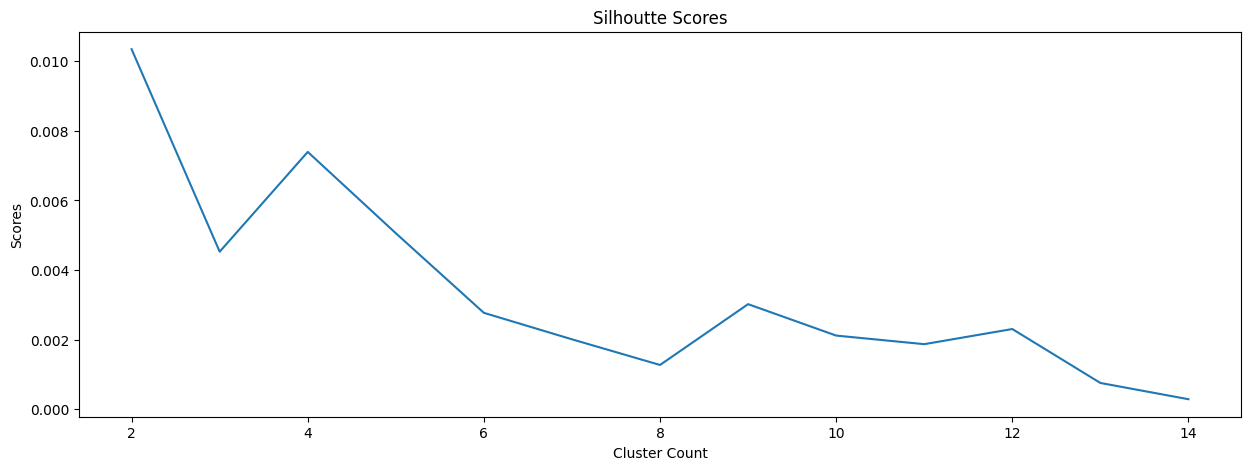

In [ ]:
cluster_evaluation(silhouette_scores, cluster_count, "Silhoutte Scores")


Max Value:
Cluster #    Cluster Score
2       0.010349

Min Value:
Cluster #     Cluster Score
14       0.000283


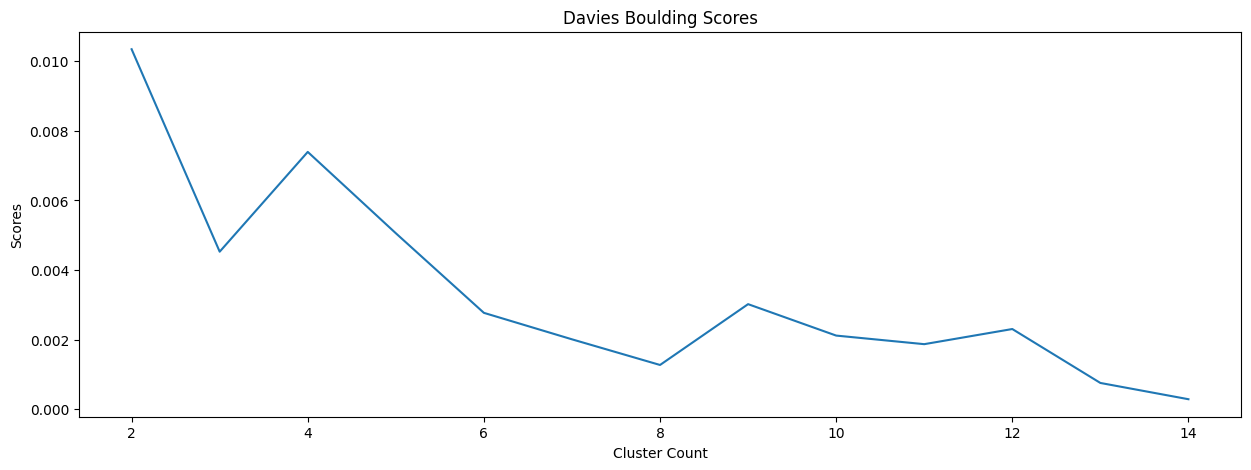

In [ ]:
cluster_evaluation(silhouette_scores, cluster_count, "Davies Boulding Scores")

In [ ]:
hac = AgglomerativeClustering(n_clusters=3, linkage='complete')
hac.fit(df_pca)
cluster_assignments = hac.labels_ 
cluster_assignments


array([1, 1, 1, ..., 2, 1, 1], shape=(6600,))

In [ ]:
df['Cluster #'] = cluster_assignments
vect_df['Cluster #'] = cluster_assignments

In [ ]:
with open("data//refined_cluster.pkl",'wb') as fp:
    pickle.dump(df, fp)
    
with open("data//vectorized_refined_cluster.pkl", 'wb') as fp:
    pickle.dump(vect_df, fp)